In [ ]:
#pip install split-folders


    pytz (>dev)
         ~^

[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#pip install mediapipe

^C
Note: you may need to restart the kernel to use updated packages.


In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import mediapipe as mp
import cv2
import os
import splitfolders
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
# Step 1: Preprocess Data with MediaPipe
def preprocess_with_mediapipe(input_folder, output_folder):
    mp_face_detection = mp.solutions.face_detection
    face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for label in os.listdir(input_folder):
        label_folder = os.path.join(input_folder, label)
        output_label_folder = os.path.join(output_folder, label)

        if not os.path.exists(output_label_folder):
            os.makedirs(output_label_folder)

        for image_file in os.listdir(label_folder):
            image_path = os.path.join(label_folder, image_file)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Failed to load image: {image_path}")
                continue

            # Detect faces
            results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if results.detections:
                for detection in results.detections:
                    bboxC = detection.location_data.relative_bounding_box
                    ih, iw, _ = image.shape
                    x, y, w, h = (int(bboxC.xmin * iw), int(bboxC.ymin * ih),
                                  int(bboxC.width * iw), int(bboxC.height * ih))
                    if x >= 0 and y >= 0 and x + w <= iw and y + h <= ih:
                        cropped_face = image[y:y + h, x:x + w]
                        # Save processed face
                        output_path = os.path.join(output_label_folder, image_file)
                        cv2.imwrite(output_path, cropped_face)
                    else:
                        print(f"Invalid bounding box for image: {image_path}")
            else:
                print(f"No face detected in image: {image_path}")

    print("Preprocessing completed with MediaPipe.")


In [9]:
# Preprocess images
preprocess_with_mediapipe("../Dataset/Foto Greyscale" , "../Dataset/Foto Test CNN" )

Invalid bounding box for image: ../Dataset/Foto Greyscale\Dimas\Dimas_12.jpg
Invalid bounding box for image: ../Dataset/Foto Greyscale\Dimas\Dimas_7.jpg
Invalid bounding box for image: ../Dataset/Foto Greyscale\Fadlin\Fadlin_8.jpg
Invalid bounding box for image: ../Dataset/Foto Greyscale\Hafidz\Hafidz_1.jpg
Invalid bounding box for image: ../Dataset/Foto Greyscale\Hafidz\Hafidz_10.jpg
Invalid bounding box for image: ../Dataset/Foto Greyscale\Hafidz\Hafidz_12.jpg
Invalid bounding box for image: ../Dataset/Foto Greyscale\Hafidz\Hafidz_4.jpg
Invalid bounding box for image: ../Dataset/Foto Greyscale\Hafidz\Hafidz_8.jpg
No face detected in image: ../Dataset/Foto Greyscale\Khansa\Khansa_2.jpg
Preprocessing completed with MediaPipe.


In [10]:
# Step 2: Split Dataset into Train, Validation, and Test
splitfolders.ratio(
    "../Dataset/Foto Test CNN",  # Input folder after preprocessing
    output="../Dataset/Data CNNs",  # Output folder
    seed=42,
    ratio=(0.7, 0.15, 0.15)  # Train:Validation:Test ratio
)
print("Dataset splitting completed.")

Copying files: 337 files [00:04, 79.92 files/s] 

Dataset splitting completed.


In [36]:
# Step 3: Load Dataset with ImageDataGenerator
datagen = ImageDataGenerator(rescale=1/255)

train_dataset = datagen.flow_from_directory(
    "../Dataset/Data CNNs/train",
    target_size=(30, 30),
    batch_size=16,
    class_mode='categorical'
)

validation_dataset = datagen.flow_from_directory(
    "../Dataset/Data CNNs/val",
    target_size=(30, 30),
    batch_size=16,
    class_mode='categorical'
)
test_dataset = datagen.flow_from_directory(
    "../Dataset/Data CNNs/test",
    target_size=(30, 30),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for evaluation
)

Found 232 images belonging to 15 classes.


Found 46 images belonging to 15 classes.
Found 59 images belonging to 15 classes.


In [2]:
from process_image import *
from model_nn import *

In [39]:
# Step 4: Build CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(30, 30, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(train_dataset.class_indices), activation='softmax')  # Output = number of classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
class StopWhenAccuracyIsOne(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')  # Retrieve val_accuracy from logs
        if val_acc is not None and val_acc >= 1.0:
            print(f"\nStopping training as val_accuracy reached {val_acc} at epoch {epoch + 1}")
            self.model.stop_training = True

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max', verbose=1)

# Initialize the custom callback
custom_early_stopping = StopWhenAccuracyIsOne()

# Model training with custom callback
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=1500,
    callbacks=[custom_early_stopping, early_stopping]
)

Epoch 1/1500
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 361ms/step - accuracy: 0.0937 - loss: 2.6998 - val_accuracy: 0.1087 - val_loss: 2.6719
Epoch 2/1500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - accuracy: 0.1174 - loss: 2.6662 - val_accuracy: 0.1087 - val_loss: 2.6608
Epoch 3/1500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - accuracy: 0.1136 - loss: 2.6741 - val_accuracy: 0.1739 - val_loss: 2.6216
Epoch 4/1500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 0.1842 - loss: 2.6044 - val_accuracy: 0.1304 - val_loss: 2.5709
Epoch 5/1500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.1339 - loss: 2.5163 - val_accuracy: 0.1522 - val_loss: 2.4763
Epoch 6/1500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - accuracy: 0.2417 - loss: 2.3945 - val_accuracy: 0.4130 - val_loss: 2.2787
Epoch 7/1500
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - accuracy: 0.3800 - loss: 2.1490 - val_accuracy: 0.3261 - val_loss: 1.9181
Epoch 8/1500
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 294ms/step - accuracy: 0.4929 - loss: 1.7010 - val_accuracy: 0.

In [19]:
# Step 6: Save the Model
model.save('70x70_Good.h5')
print("Model training completed and saved.")

Model training completed and saved.


In [34]:
# Step 7: Evaluate Model on Test Set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8575 - loss: 0.6512
Test Accuracy: 0.86


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/stepWARNING:tensorflow:6 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001C9EF7710D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


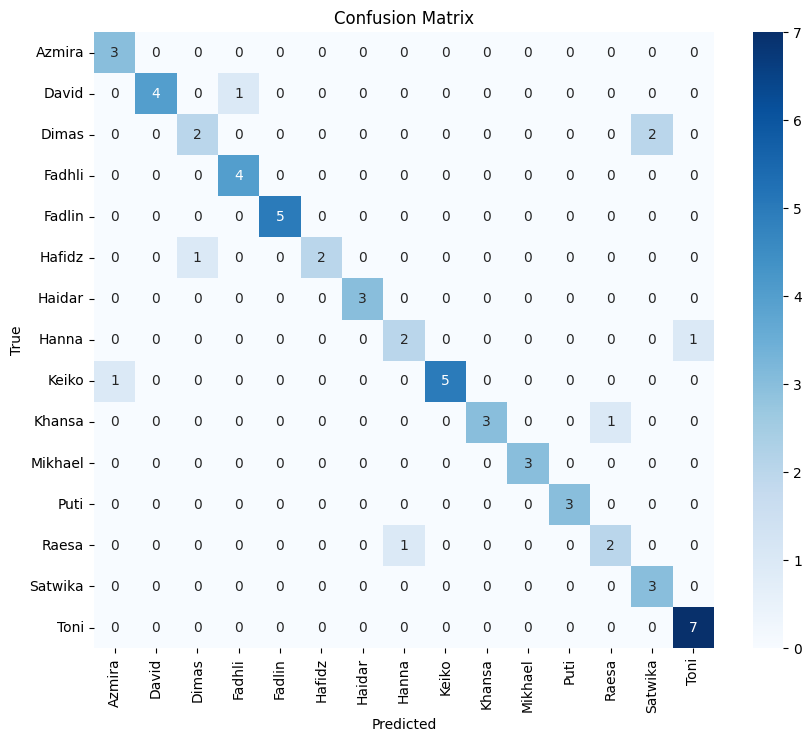

Classification Report:
              precision    recall  f1-score   support

      Azmira       0.75      1.00      0.86         3
       David       1.00      0.80      0.89         5
       Dimas       0.67      0.50      0.57         4
      Fadhli       0.80      1.00      0.89         4
      Fadlin       1.00      1.00      1.00         5
      Hafidz       1.00      0.67      0.80         3
      Haidar       1.00      1.00      1.00         3
       Hanna       0.67      0.67      0.67         3
       Keiko       1.00      0.83      0.91         6
      Khansa       1.00      0.75      0.86         4
     Mikhael       1.00      1.00      1.00         3
        Puti       1.00      1.00      1.00         3
       Raesa       0.67      0.67      0.67         3
     Satwika       0.60      1.00      0.75         3
        Toni       0.88      1.00      0.93         7

    accuracy                           0.86        59
   macro avg       0.87      0.86      0.85        59
wei

In [35]:
# Step 8: Generate Confusion Matrix
Y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(Y_pred, axis=1)  # Predicted class
y_true = test_dataset.classes  # True labels

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.class_indices.keys(), yticklabels=test_dataset.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=test_dataset.class_indices.keys())
print("Classification Report:")
print(report)